# Two Planet Fit: Kepler 29

In [2]:
import exoplanet as xo
import lightkurve as lk
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time

import sys
sys.path.append("../helpers")
import data
import xo_archive

%config InlineBackend.figure_format = "retina"

# Get the data

Get all Kepler data using Lightkurve.

In [50]:
%%time
flat_lc = data.get_flattened_lc("Kepler-29", mission="Kepler", exptime=1800)

CPU times: user 13.1 s, sys: 19.6 s, total: 32.7 s
Wall time: 7.56 s


In [53]:
from importlib import reload
reload(xo_archive)

<module 'xo_archive' from '/home/tom/Documents/research/radius-valley/notebooks/../helpers/xo_archive.py'>

In [45]:
xo_archive.get_exoplanet_parameters(search_name="Kepler", custom_cond="sy_pnum=2 and ttv_flag=0", columns=["pl_name", "pl_letter"])

[{'pl_name': 'Kepler-462 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-466 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-495 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-120 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-121 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-109 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-118 c', 'pl_letter': 'c'},
 {'pl_name': 'Kepler-501 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-119 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-123 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-112 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-116 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-69 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-115 c', 'pl_letter': 'c'},
 {'pl_name': 'Kepler-105 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-458 c', 'pl_letter': 'c'},
 {'pl_name': 'Kepler-94 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-125 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-424 b', 'pl_letter': 'b'},
 {'pl_name': 'Kepler-120 c', 'pl_letter': 'c'},
 {'pl_name': 'Kepler-109 c', 'pl_letter': 

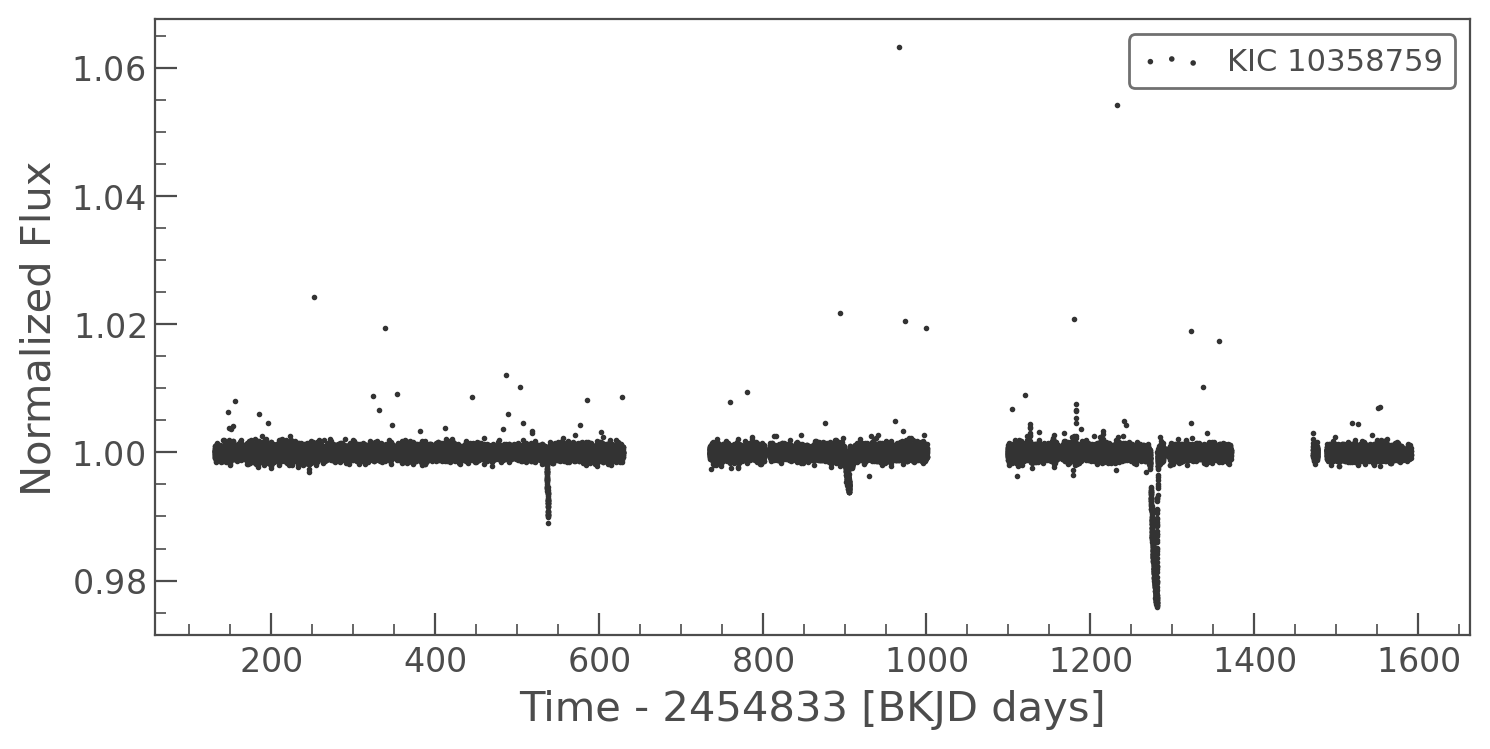

In [51]:
flat_lc.scatter()
plt.show()

# Remove outliers
Next we can remove outliers from the data, this is important but we have to be careful to avoid the transits. First we need the planet data

In [54]:
planet_parameters = xo_archive.get_exoplanet_parameters("kepler-29 ", which="composite")
n_planets = len(planet_parameters)
param_lists = xo_archive.transpose_parameters(planet_parameters)

In [58]:
lc = data.remove_outliers(flat_lc, param_lists["pl_orbper"], param_lists["pl_tranmid"], param_lists["pl_trandur"],
                          transit_sigma_upper=5)

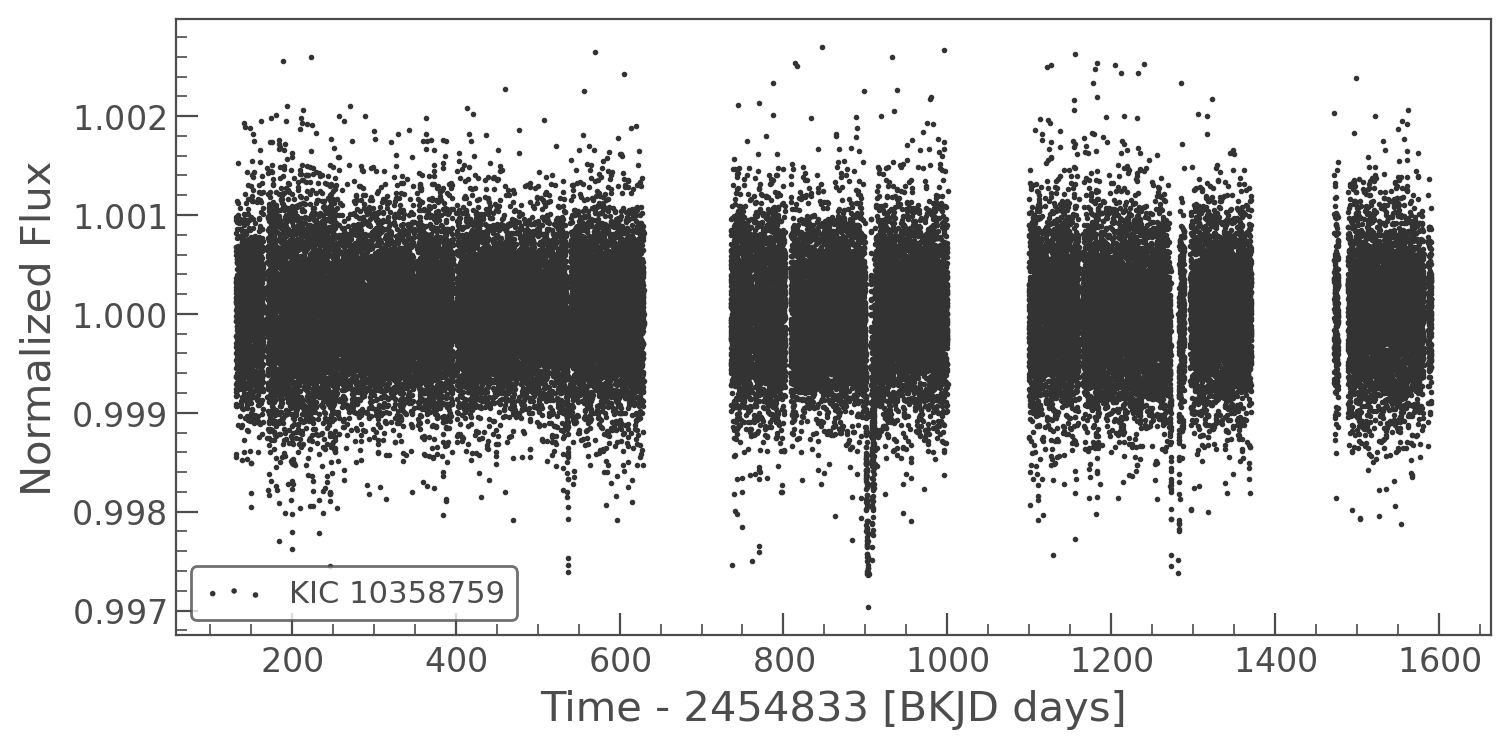

In [59]:
lc.scatter()
plt.show()

## Folded lightcurves

Now we can try folding the lightkurves at the different planet periods to check that they look good

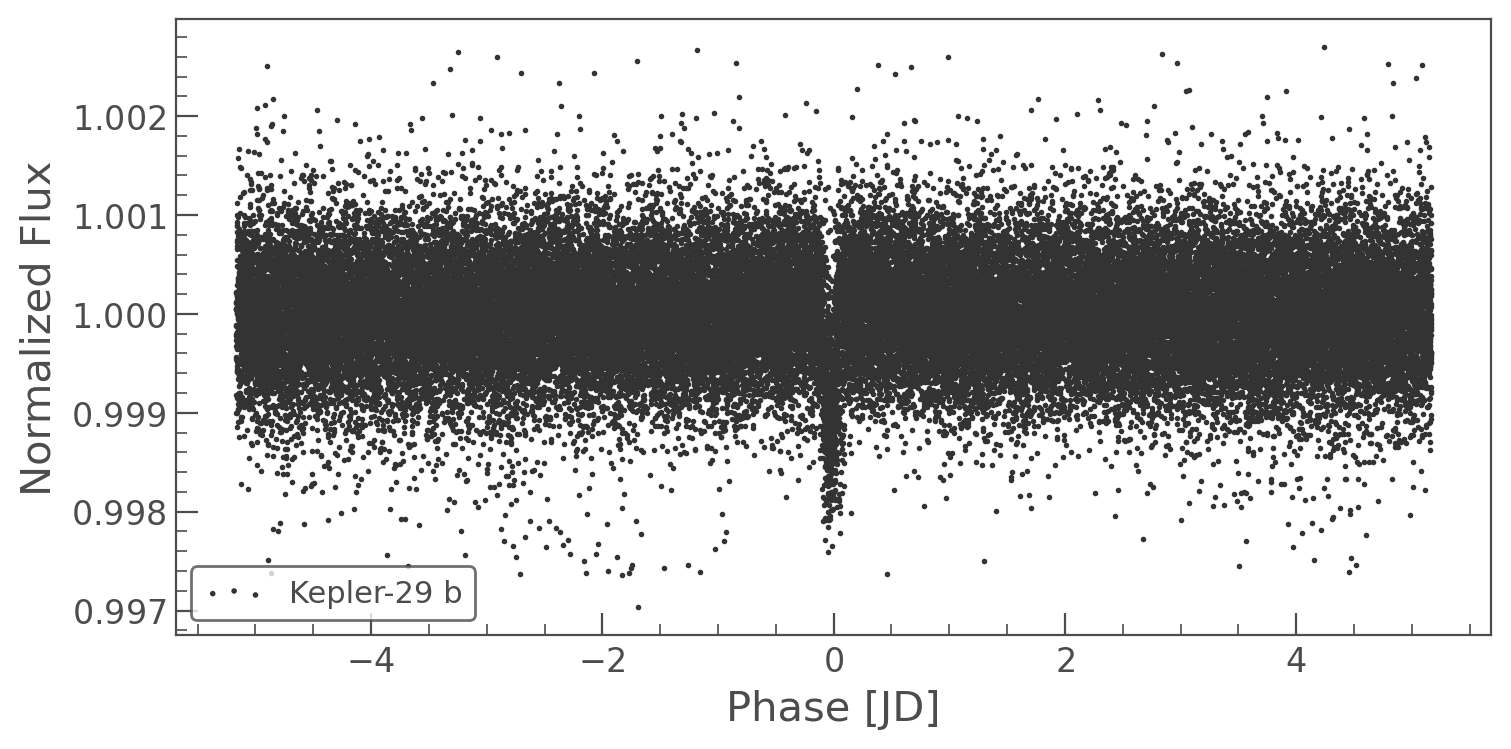

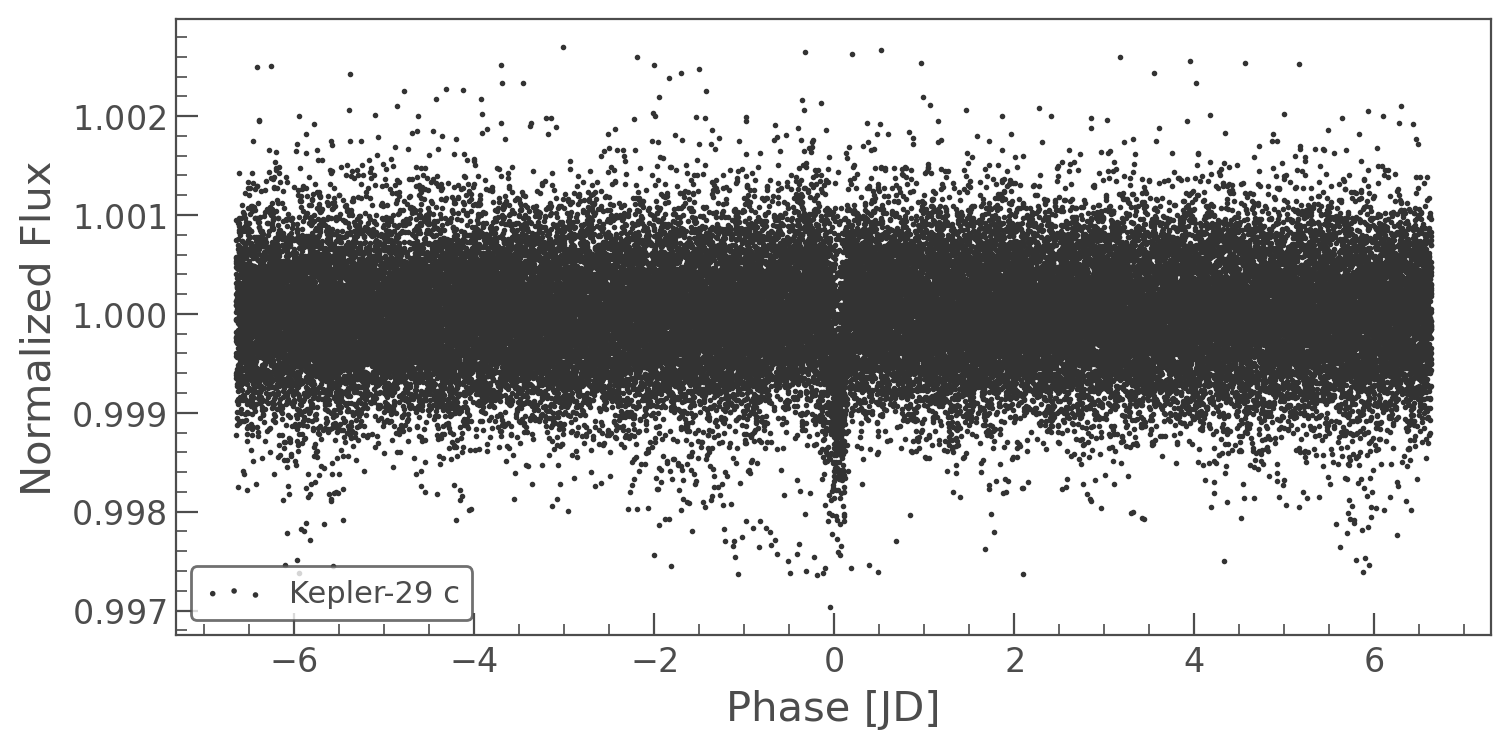

In [60]:
for i in range(len(planet_parameters)):
    ax = lc.fold(period=planet_parameters[i]["pl_orbper"],
                 epoch_time=Time(planet_parameters[i]["pl_tranmid"] * u.day, format="jd").bkjd).scatter(label=planet_parameters[i]["pl_name"])
    plt.show()

# Now to fit things

In [61]:
import fit

In [69]:
len(lc)

51116

In [68]:
map_soln = fit.optimise_model(lc, param_lists)

optimizing logp for variables: [log_rho_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 310777.7977656473 -> 311826.03137911175


In [71]:
map_soln

{'mean': array(1.00000708),
 't0': array([170.38645957, 172.1130211 ]),
 'logP': array([2.33594863, 2.58678157]),
 'u_quadlimbdark__': array([1.96458373, 2.586187  ]),
 'r_interval__': array([-0.9797019 , -1.35313278]),
 'b_impact__': array([ 0.31310802, -0.47091564]),
 'log_rho_star': array(0.02035942),
 'period': array([10.33926339, 13.2869396 ]),
 'u': array([ 1.74182468, -0.80532686]),
 'r': array([0.02802214, 0.02133051]),
 'b': array([0.59383053, 0.39259899]),
 'rho_star': array(1.04799551),
 'light_curves': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])}

In [75]:
updated_params = {}
updated_params["pl_orbper"] = map_soln["period"]
updated_params["pl_tranmid"] = Time(map_soln["t0"], format="bkjd").jd
updated_params["pl_ratror"] = map_soln["r"]
updated_params["pl_imppar"] = map_soln["b"]
updated_params["st_dens"] = [map_soln["rho_star"]]

new_soln = fit.optimise_model(lc, updated_params, u_init=map_soln["u"])

optimizing logp for variables: [log_rho_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 311819.6822243942 -> 311826.1519083546


# Let's see how the fit looks

In [63]:
param_lists

{'pl_name': ['Kepler-29 b', 'Kepler-29 c'],
 'pl_letter': ['b', 'c'],
 'pl_orbper': [10.33974, 13.28613],
 'pl_orbincl': [89.13, 89.97],
 'pl_orbeccen': [0.0, 0.0],
 'pl_trandep': [0.102, 0.10396],
 'pl_tranmid': [2455003.38549, 2455005.11932],
 'pl_trandur': [3.041, 3.2825],
 'pl_ratror': [0.03194, 0.02928],
 'pl_imppar': [0.379, 0.929],
 'st_dens': [3.18827, 3.45528]}

In [76]:
map_soln

{'mean': array(1.00000708),
 't0': array([170.38645957, 172.1130211 ]),
 'logP': array([2.33594863, 2.58678157]),
 'u_quadlimbdark__': array([1.96458373, 2.586187  ]),
 'r_interval__': array([-0.9797019 , -1.35313278]),
 'b_impact__': array([ 0.31310802, -0.47091564]),
 'log_rho_star': array(0.02035942),
 'period': array([10.33926339, 13.2869396 ]),
 'u': array([ 1.74182468, -0.80532686]),
 'r': array([0.02802214, 0.02133051]),
 'b': array([0.59383053, 0.39259899]),
 'rho_star': array(1.04799551),
 'light_curves': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])}

In [77]:
new_soln

{'mean': array(1.00000708),
 't0': array([170.38635925, 172.11306587]),
 'logP': array([2.33594872, 2.5867815 ]),
 'u_quadlimbdark__': array([1.98587914, 2.59110789]),
 'r_interval__': array([-0.9629258 , -1.33862185]),
 'b_impact__': array([ 0.37303245, -0.35834083]),
 'log_rho_star': array(0.00290815),
 'period': array([10.33926434, 13.2869387 ]),
 'u': array([ 1.74468543, -0.80697199]),
 'r': array([0.02835299, 0.02156594]),
 'b': array([0.60898192, 0.42023266]),
 'rho_star': array(1.00671874),
 'light_curves': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])}

In [67]:
1 - np.array([ 1.74182468, -0.80532686]).sum()

0.06350218000000007

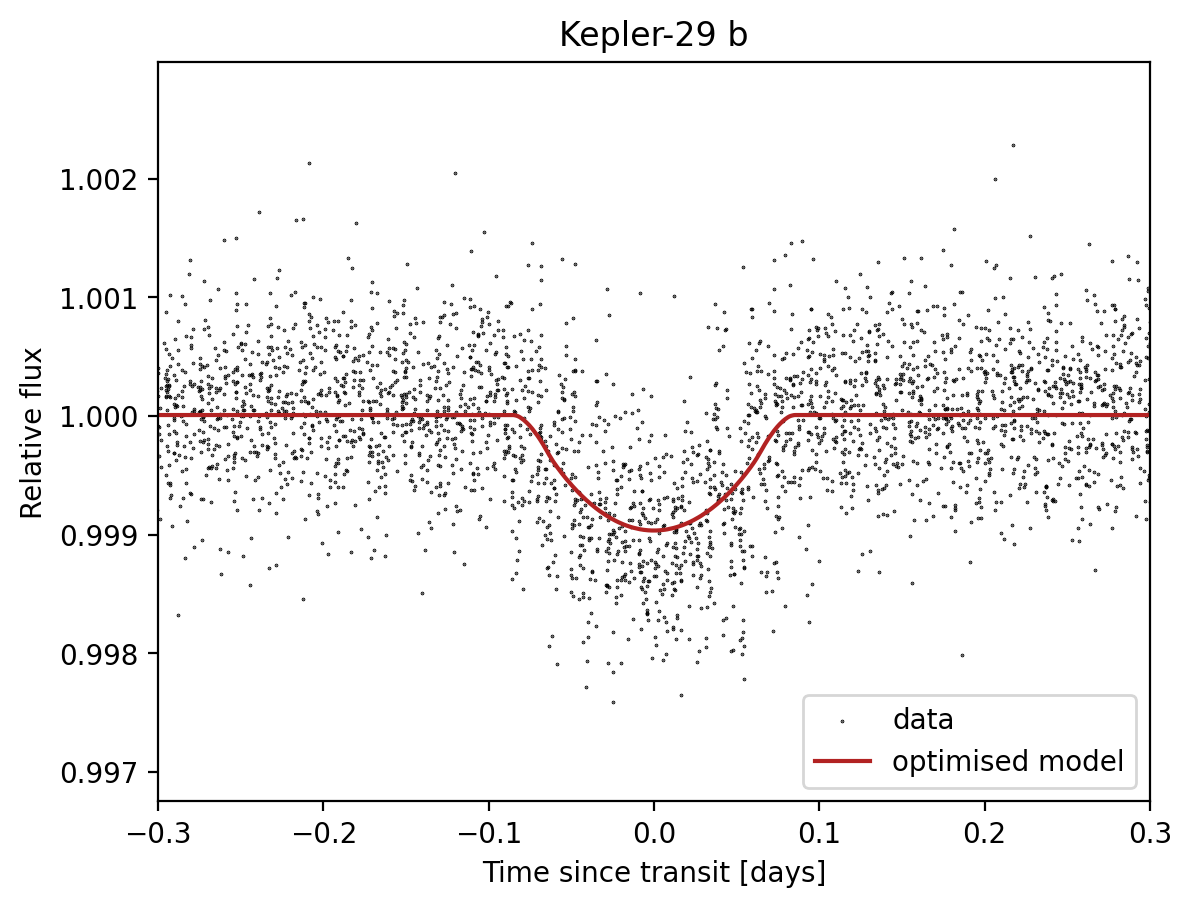

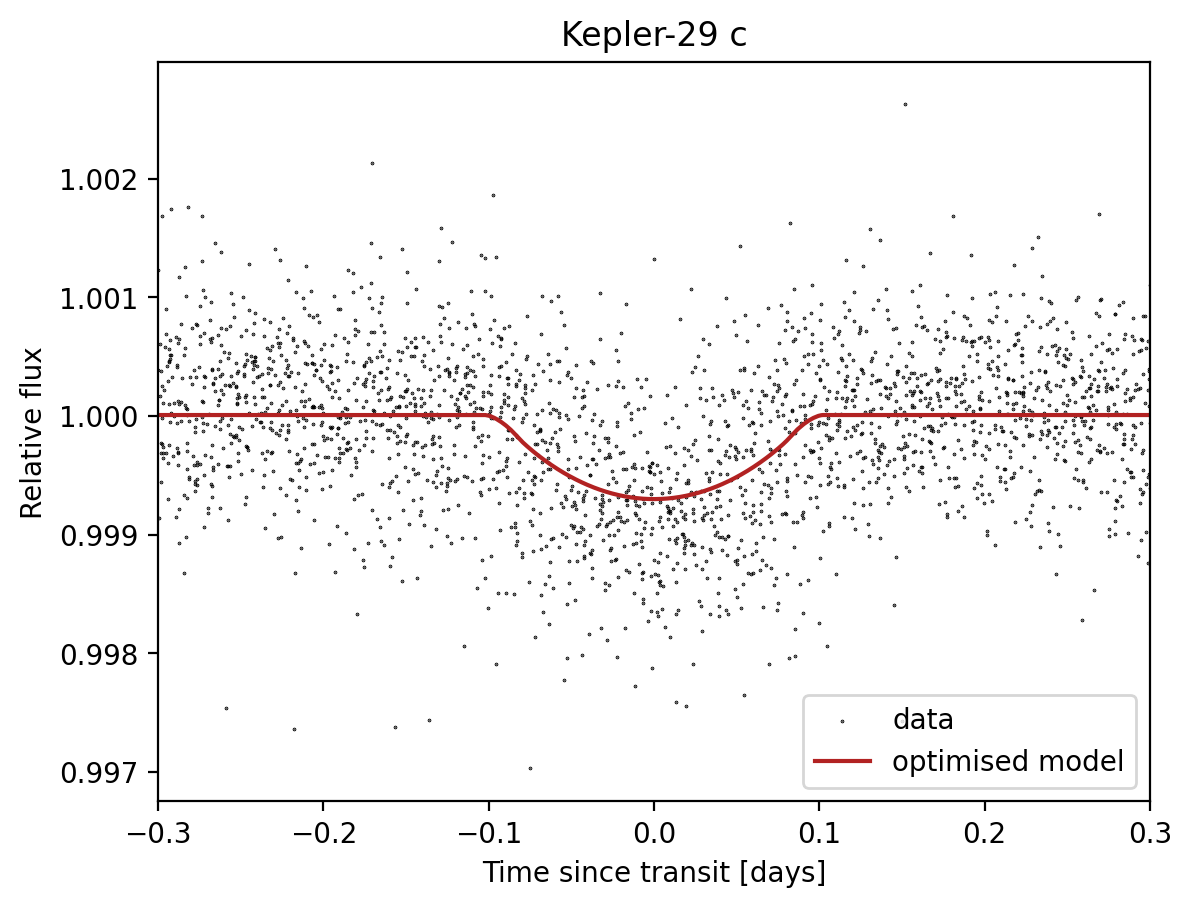

In [65]:
t = lc["time"].value
y = lc["flux"].value

for i in range(n_planets):
    plt.figure()

    p = map_soln["period"][i]
    t0 = map_soln["t0"][i]

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.scatter(
        x_fold, y, label="data", zorder=-1000, s=0.1, color="black"
    )

    # Plot the folded model within 0.3 days of the transit
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = map_soln["light_curves"][inds, i] + map_soln["mean"]
    plt.plot(x_fold[inds], pred, color="firebrick", label="optimised model")
    plt.plot(x_fold[inds], pred, color="firebrick", label="re-optimised model")

    plt.ylabel("relative flux")
    plt.xlabel("time [days]")
    _ = plt.xlim(t.min(), t.max())

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("Time since transit [days]")
    plt.ylabel("Relative flux")
    plt.title(param_lists["pl_name"][i])
    plt.xlim(-0.3, 0.3)
    plt.show()